# 835 Final Project

In [12]:
!wget https://raw.githubusercontent.com/HobbitLong/SupContrast/refs/heads/master/losses.py

--2024-12-05 12:57:33--  https://raw.githubusercontent.com/HobbitLong/SupContrast/refs/heads/master/losses.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4137 (4.0K) [text/plain]
Saving to: ‘losses.py.1’

losses.py.1         100%[===================>]   4.04K  --.-KB/s    in 0s      

2024-12-05 12:57:34 (28.6 MB/s) - ‘losses.py.1’ saved [4137/4137]



In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as vF
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import v2
from torchvision.models import shufflenet_v2_x1_0
from timm.models.swin_transformer import SwinTransformer
from sklearn.linear_model import LinearRegression
import kagglehub
import numpy as np
import os
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from losses import SupConLoss
from torch.nn import TripletMarginLoss
import random
from Utils import GetDataset

c:\Users\tsope\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Model
Model architecture based on TractoSCR

In [2]:
class SupConModel(nn.Module):
  def __init__(self, feature_dim : int = 128, device : str = "cpu")->None:
    super(SupConModel, self).__init__()
    self.backbone = shufflenet_v2_x1_0(pretrained=True)
    self.backbone.conv1[0] = nn.Conv2d(1, 24, kernel_size=3, stride=2, padding=1)
    self.backbone.classifier     = nn.Identity().to(device)
    self.linear = nn.Linear(1000, feature_dim)
    self.encoder = nn.Sequential(
      self.backbone,
      self.linear
    ).to(device)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, X):
    X = self.encoder(X)
    X = self.softmax(X)

    return X

class PairDet:
  def __init__(self, threshold : float = 1.0):
    self.T = threshold

  def __call__(self, y : torch.Tensor)->torch.Tensor:
    # A positive pair is when |yi - yj| <= T, were i, j in N
    # This returns a square matrix of (N, N) where
    # each row is an image, and each column where Aij = 1 is a positive pair
    #

    # replicate y, such that [y, y, ..., y] for N columns
    N  = len(y)
    Y  = y.expand(-1, N)
    Q  = torch.abs(Y - Y.T) <= self.T

    return Q

### Model training

In [3]:
# Hyperparameters
batch_size  = 128
epochs      = 400
lr          = 1e-3
split_ratio = 0.9   # %
device      = "cuda:0"
views       = 5
features_dim = 256

sz = (126, 126)
dataset = GetDataset(data_augmentation=True, n_views=2)

# Get the total size of the dataset
dataset_size = len(dataset)

# Calculate sizes for training and validation splits
train_size = int(split_ratio * dataset_size)
val_size = dataset_size - train_size

# Perform the split
generator1 = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator1)

# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True )
val_loader   = DataLoader(val_dataset  , batch_size=batch_size, shuffle=False)

supconmodel = SupConModel(features_dim, device)
optimizer   = torch.optim.Adam(supconmodel.parameters(), lr=lr, weight_decay=1e-5)
pdr         = PairDet(threshold = 1)
lossfn      = SupConLoss(base_temperature=0.001, temperature=0.01)

total_losses = []
for epoch in range(epochs):
  supconmodel.train()
  print(f'########################################')
  print(f'Epoch: {epoch+1}')

  losses = 0
  count  = 0
  for images, temperatures in train_loader:
    N      = images.shape[0]
    V      = images.shape[1]
    images = images.reshape(N * V, 1, sz[0], sz[1])
    temperatures = temperatures.unsqueeze(1).expand(-1, V).reshape(N * V, 1)
    ##
    ##
    ##
    pairs = pdr(temperatures).float() - torch.eye(N * V, N * V, device=device).float()
    proj  = supconmodel(images).unsqueeze(1)
    loss  = lossfn(proj, mask=pairs)

    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses += loss.cpu().detach().numpy()
    count  += 1
    print(f'*', end='')
  print('\n')
  print(f'Loss: {losses / count}')
  total_losses.append(losses / count)
total_losses = np.array(total_losses).squeeze()

Path to dataset files: C:\Users\tsope\.cache\kagglehub\datasets\juanda220485\synthetic-dataset-of-speckle-images\versions\1


c:\Users\tsope\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\tsope\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


########################################
Epoch: 1
*****

Loss: 53.28087387084961
########################################
Epoch: 2
*****

Loss: 55.01309661865234
########################################
Epoch: 3
*****

Loss: 54.237501525878905
########################################
Epoch: 4
*****

Loss: 55.438272857666014
########################################
Epoch: 5
*****

Loss: 54.70308303833008
########################################
Epoch: 6
*****

Loss: 54.276040649414064
########################################
Epoch: 7
*****

Loss: 53.62852935791015
########################################
Epoch: 8
*****

Loss: 52.79128494262695
########################################
Epoch: 9
*****

Loss: 52.51011428833008
########################################
Epoch: 10
*****

Loss: 52.60927047729492
########################################
Epoch: 11
*****

Loss: 52.40067367553711
########################################
Epoch: 12
*****

Loss: 52.40226440429687
######################

KeyboardInterrupt: 

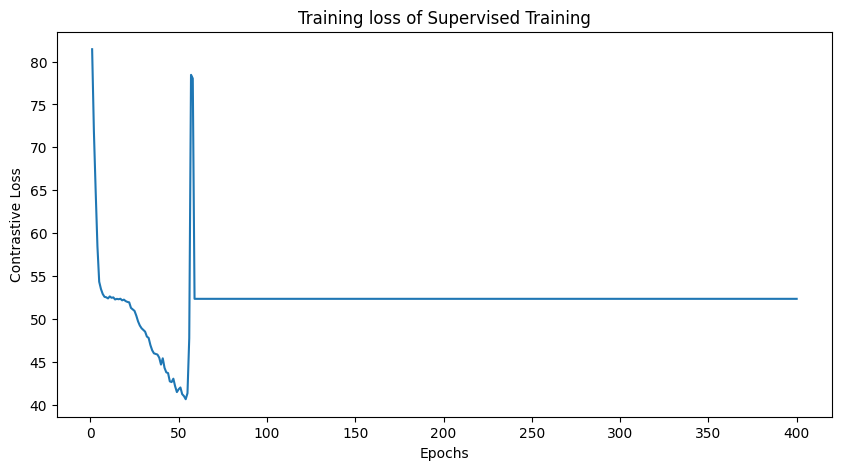

In [14]:
plt.figure(figsize=[10, 5])
plt.plot(np.arange(1, epochs+1), total_losses)
plt.xlabel("Epochs")
plt.ylabel("Contrastive Loss")
plt.title("Training loss of Supervised Training")
plt.show()

In [15]:
torch.save(supconmodel, "shufflenetv2_encoder_model1_c_400ep_64e_r_200ep_1.pth")
np.save('shufflenetv2_supcon_loss.npy', total_losses)

### Fine-tuning

In [16]:
class RegressionModel(torch.nn.Module):
  def __init__(self, supconmodel : SupConModel, features_dim : int = 128, device : str = 'cpu')->None:
    super(RegressionModel, self).__init__()
    self.encoder = supconmodel.encoder

    for param in self.encoder.parameters():
      param.requires_grad = False

    self.head = nn.Sequential (
      nn.Linear(features_dim, features_dim//2),
      nn.ReLU(),
      nn.Linear(features_dim//2, 1),
    ).to(device)

  def forward(self, X):
    with torch.no_grad():
      X = self.encoder(X)
    X = self.head(X)

    return X

In [17]:
batch_size  = 64
epochs      = 200
lr          = 1e-3
split_ratio = 0.9   # %
device      = "cuda:0"
views       = 5
features_dim = features_dim

dataset = GetDataset(data_augmentation=False)

# Get the total size of the dataset
dataset_size = len(dataset)

# Calculate sizes for training and validation splits
train_size = int(split_ratio * dataset_size)
val_size = dataset_size - train_size

# Perform the split
generator1 = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator1)

# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True )
val_loader   = DataLoader(val_dataset  , batch_size=batch_size, shuffle=False)

regmodel = RegressionModel(supconmodel, features_dim, device)
optimizer   = torch.optim.Adam(regmodel.parameters(), lr=lr, weight_decay=1e-4)
lossfn      = torch.nn.MSELoss()

tlosses = []
vlosses = []
r2s     = []
for epoch in range(epochs):
  regmodel.train()
  print(f'########################################')
  print(f'Epoch: {epoch+1}')
  losses = 0
  count  = 0
  for images, temperatures in train_loader:
    N = images.shape[0]
    V = images.shape[1]
    images = images.to(device).reshape(N * V, 1, sz[0], sz[1])
    temperatures = temperatures.to(device).unsqueeze(1).expand(-1, V).reshape(N * V, 1)
    ##
    ##
    ##
    pred  = regmodel(images)
    loss  = lossfn(pred, temperatures)

    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses += loss.cpu().detach().numpy()
    count  += 1

    print(f'*', end='')
  print('\n')
  print(f'MSE : {losses / count}')
  print(f'RMSE: {np.sqrt(losses / count)}')
  tlosses.append(losses / count)

  with torch.no_grad():
    losses = 0
    count  = 0
    y_pred = []
    y_test = []
    for images, temperatures in val_loader:
      N = images.shape[0]
      V = images.shape[1]
      images = images.to(device).reshape(N * V, 1, sz[0], sz[1])
      temperatures = temperatures.to(device).unsqueeze(1).expand(-1, V).reshape(N * V, 1)
      pred = regmodel(images)
      loss = lossfn(pred, temperatures)
      losses += loss.cpu().detach().numpy()
      count += 1

      y_pred.append(pred.squeeze().cpu().detach().numpy())
      y_test.append(temperatures.squeeze().cpu().detach().numpy())
      
  y_pred = np.array(y_pred).flatten()
  y_test = np.array(y_test).flatten()

  r2 = r2_score(y_test, y_pred)
  print(f'Validation: MSE : {losses / count}')
  print(f'Validation: RMSE: {np.sqrt(losses / count)}')
  print(f'Validation R2: {r2}')
  vlosses.append(losses / count)
  r2s.append(r2)


Path to dataset files: C:\Users\tsope\.cache\kagglehub\datasets\juanda220485\synthetic-dataset-of-speckle-images\versions\1
########################################
Epoch: 1
*********

MSE : 4451.201253255208
RMSE: 66.71732348689663
Validation: MSE : 4400.29052734375
Validation: RMSE: 66.33468570321072
Validation R2: -2.4349544048309326
########################################
Epoch: 2
*********

MSE : 4108.296875
RMSE: 64.09599733992755
Validation: MSE : 4028.06787109375
Validation: RMSE: 63.467061308160076
Validation R2: -2.1443896293640137
########################################
Epoch: 3
*********

MSE : 3781.7358127170137
RMSE: 61.495819473497654
Validation: MSE : 3662.718017578125
Validation: RMSE: 60.52039340237409
Validation R2: -1.8591902256011963
########################################
Epoch: 4
*********

MSE : 3427.1552463107637
RMSE: 58.54191016964482
Validation: MSE : 3302.729736328125
Validation: RMSE: 57.46938085909857
Validation R2: -1.578176498413086
#################

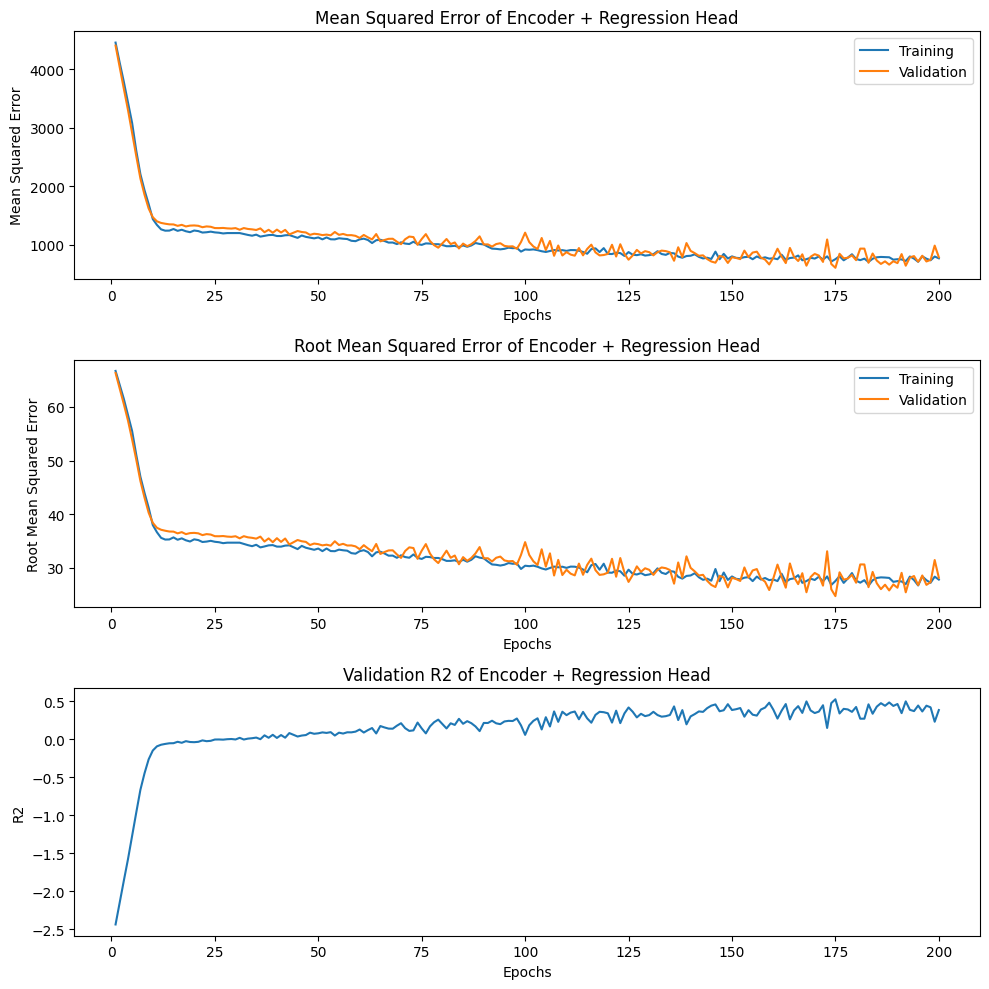

In [18]:
output_file_path = "shufflenetv2_regression_model1_supervised_contrastive_view_2_t1.0_256e.txt"
def print_regression_losses():
    mse_values = []
    validation_mse_values = []
    validation_r2_values = []

    with open(output_file_path, 'r') as file:
        for line in file:
            if "MSE :" in line and "Validation" not in line:
                mse_values.append(float(line.split("MSE :")[1].strip()))
            elif "Validation: MSE :" in line:
                validation_mse_values.append(float(line.split("Validation: MSE :")[1].strip()))
            elif "Validation R2:" in line:
                validation_r2_values.append(float(line.split("Validation R2:")[1].strip()))
    mse_values = np.array(mse_values)
    validation_mse_values = np.array(validation_mse_values)
    validation_r2_values = np.array(validation_r2_values)
    num_epochs_r = np.arange(1, 201)

    plt.figure(figsize=[10, 10])
    plt.subplot(3, 1, 1)
    plt.plot(num_epochs_r, mse_values, num_epochs_r, validation_mse_values)
    plt.xlabel("Epochs")
    plt.ylabel("Mean Squared Error")
    plt.title("Mean Squared Error of Encoder + Regression Head")
    plt.legend(['Training', 'Validation'])

    plt.subplot(3, 1, 2)
    plt.plot(num_epochs_r, np.sqrt(mse_values), num_epochs_r, np.sqrt(validation_mse_values))
    plt.xlabel("Epochs")
    plt.ylabel("Root Mean Squared Error")
    plt.title("Root Mean Squared Error of Encoder + Regression Head")
    plt.legend(['Training', 'Validation'])

    plt.subplot(3, 1, 3)
    plt.plot(num_epochs_r, validation_r2_values)
    plt.xlabel("Epochs")
    plt.ylabel("R2")
    plt.title("Validation R2 of Encoder + Regression Head")

    plt.tight_layout()
    plt.show()
# print_regression_losses()

mse_values = np.array(tlosses)
validation_mse_values = np.array(vlosses)
validation_r2_values = np.array(r2s)
num_epochs_r = np.arange(1, len(mse_values)+1)

plt.figure(figsize=[10, 10])
plt.subplot(3, 1, 1)
plt.plot(num_epochs_r, mse_values, num_epochs_r, validation_mse_values)
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error")
plt.title("Mean Squared Error of Encoder + Regression Head")
plt.legend(['Training', 'Validation'])

plt.subplot(3, 1, 2)
plt.plot(num_epochs_r, np.sqrt(mse_values), num_epochs_r, np.sqrt(validation_mse_values))
plt.xlabel("Epochs")
plt.ylabel("Root Mean Squared Error")
plt.title("Root Mean Squared Error of Encoder + Regression Head")
plt.legend(['Training', 'Validation'])

plt.subplot(3, 1, 3)
plt.plot(num_epochs_r, validation_r2_values)
plt.xlabel("Epochs")
plt.ylabel("R2")
plt.title("Validation R2 of Encoder + Regression Head")

plt.tight_layout()
plt.show()


In [19]:
torch.save(regmodel, "shufflenetv2_regression_model_c_400ep_64e_r_200ep_1.pth")
np.save('train_losses.npy', mse_values)
np.save('val_losses.npy', validation_mse_values)
np.save('val_r2.npy', validation_r2_values)

In [ ]:
with torch.no_grad():
    losses = 0
    count  = 0
    y_pred = []
    y_test = []
    for images, temperatures in val_loader:
      N = images.shape[0]
      V = images.shape[1]
      images = images.to(device).reshape(N * V, 1, sz[0], sz[1])
      temperatures = temperatures.to(device).unsqueeze(1).expand(-1, V).reshape(N * V, 1)
      pred = regmodel(images)
      loss = lossfn(pred, temperatures)
      losses += loss.cpu().detach().numpy()
      count += 1

      y_pred.append(pred.squeeze().cpu().detach().numpy())
      y_test.append(temperatures.squeeze().cpu().detach().numpy())
      
    y_pred = np.array(y_pred).flatten()
    y_test = np.array(y_test).flatten()

print(f'Validation: MSE : {losses / count}')
print(f'Validation: RMSE: {np.sqrt(losses / count)}')
print(f'Validation R2: {r2_score(y_test, y_pred)}')

print(f'Predicted: {y_pred[:5]}')
print(f'Actual: {y_test[:5]}')
print(f'MAE: {np.abs(y_pred - y_test).mean()}')

Validation: MSE : 15.247913360595703
Validation: RMSE: 3.904857662014802
Validation R2: 0.9880971908569336
Predicted: [ 57.912716  99.00222  111.612625  36.435947 103.17501 ]
Actual: [ 59.8 100.6 118.2  37.6 113.2]
MAE: 3.0359933376312256


### Compare to Linear Regression

The dataset https://pmc.ncbi.nlm.nih.gov/articles/PMC10139894/ approximates change in refractive index $n$ as:

$
  n \approx n_0 + C_{TO}\Delta T
$

$
  \nabla \times \nabla \times \vec{E} - k_0^{2}n^{2}\vec{E} = 0
$

Note that the total network size of the NN regression model is ~11.5 million parameters 

<>:38: SyntaxWarning: invalid escape sequence '\d'
<>:39: SyntaxWarning: invalid escape sequence '\d'
<>:38: SyntaxWarning: invalid escape sequence '\d'
<>:39: SyntaxWarning: invalid escape sequence '\d'
C:\Users\tsope\AppData\Local\Temp\ipykernel_33120\3399559355.py:38: SyntaxWarning: invalid escape sequence '\d'
  plt.xlabel(f"Temperature [$\degree C$]")
C:\Users\tsope\AppData\Local\Temp\ipykernel_33120\3399559355.py:39: SyntaxWarning: invalid escape sequence '\d'
  plt.ylabel(f"Difference in Temperature [$\degree C$]")


#######################################
Actual temperatures:		[ 22.   83.8 113.   15.4  36.2]
Predicted temperatures:		[23.816986 84.076324 98.07361  14.458313 39.70056 ]
R2: 0.9348442554473877
MSE: 97.10440063476562, RMSE: 9.854156494140625
MAE: 6.860413551330566


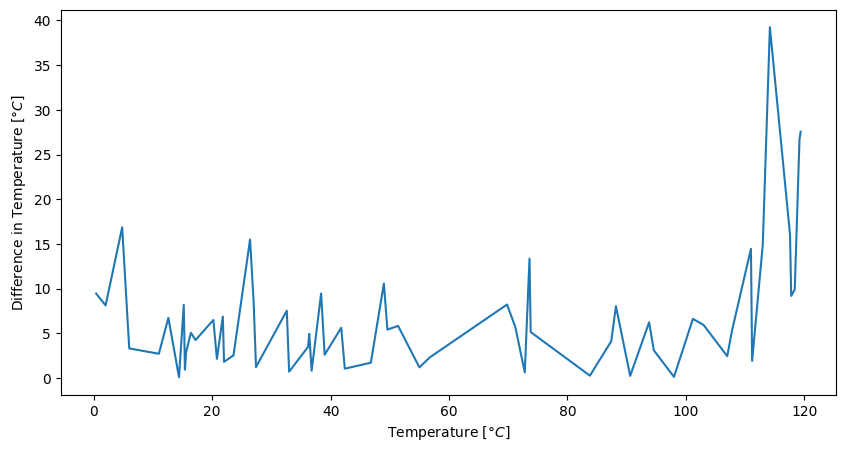

In [31]:
from sklearn.model_selection import train_test_split

X, y = dataset.numpy(raw=False)
N = X.shape[0]
V = X.shape[1]
X = torch.tensor(X).reshape(N * V, 1, sz[0], sz[1]).reshape(N * V, sz[0] * sz[1]).cpu().detach().numpy()
y = torch.tensor(y).unsqueeze(1).expand(-1, V).reshape(N * V, 1).squeeze(-1).cpu().detach().numpy()


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42)

lr_rg = LinearRegression()
lr_rg.fit(X_train, y_train)

y_pred = lr_rg.predict(X_test)


# print r2 score and predictions
print("#######################################")
print(f"Actual temperatures:\t\t{y_test[:5]}")
print(f"Predicted temperatures:\t\t{y_pred[:5]}")
print(f"R2: {r2_score(y_test, y_pred)}")
print(f"MSE: {np.mean((y_test - y_pred) ** 2)}, RMSE: {np.sqrt(np.mean((y_test - y_pred) ** 2))}")
print(f"MAE: {np.mean(np.abs(y_test - y_pred))}")

# print out differences per temperature
# Get the sorting indices from the first vector
idxs = np.argsort(y_test)

# Sort both vectors using the sorting indices
xx = y_test[idxs]
yy = np.abs(y_test - y_pred)[idxs]


plt.figure(figsize=[10, 5])
plt.plot(xx, yy)
plt.xlabel(f"Temperature [$\degree C$]")
plt.ylabel(f"Difference in Temperature [$\degree C$]")
plt.show()

## ~11.5 million parameters